Définition des fonctions

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Union, Tuple, List

Fonction pour calculer le gradient proximal


In [44]:

def compute_g(x: np.ndarray, x_prev: np.ndarray, c: float) -> np.ndarray:
    return lambda x, f: f(x) + (1/(2*c)) * np.sum((x - x_prev)**2)

def optimize_g(f: Callable, x_prev: np.ndarray, c: float,
              max_iter_inner: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    def g(x):
        return f(x) + (1/(2*c)) * np.sum((x - x_prev)**2)

    x = x_prev.copy()
    x_best = x.copy()
    f_best = g(x)

    # this is the momentum terms
    velocity = np.zeros_like(x)
    beta = 0.9  # momentum coefficient

    for iteration in range(max_iter_inner):
        # adaptive step size for decay as seen in course, not that it is a predefined one, just something I made up
        step_size = c / (1 + 0.1 * iteration)

        if np.all(np.abs(x) > 0):
            s_f = np.sign(x)
        else:
            s_f = np.zeros_like(x)

        grad_g = s_f + (1/c) * (x - x_prev)

        # applying momentum update, as we did before in that TP
        velocity = beta * velocity - step_size * grad_g
        x_new = x + velocity

        f_new = g(x_new)
        if f_new < f_best: # we keep track of the best value
            f_best = f_new
            x_best = x_new.copy()

        # convergence check with tolerance relative to x's magnitude
        if np.linalg.norm(x_new - x) < 1e-8 * (1 + np.linalg.norm(x)):
            print(f"Converged after {iteration} iterations")
            print(f"Best value found: {f_best}")
            break

        x = x_new

    # we return the best solution found
    if np.all(np.abs(x_best) > 0):
        s_final = np.sign(x_best)
    else:
        s_final = np.clip(np.random.uniform(-1, 1, size=x_best.shape), -1, 1)

    return x_best, s_final


Algorithme de descente de gradient proximal

In [45]:
def descent(f: Callable, x0: np.ndarray, c: float = 0.1,
           max_iter: int = 100, tol: float = 1e-5) -> Tuple[List[np.ndarray], List[float]]:
    x_curr = np.array(x0, dtype=float).reshape(-1)
    trajectory = [x_curr]
    f_values = [f(x_curr)]

    # patience mechanism: helps prevent premature convergence by monitoring progress; the patience meter
    patience = 10
    best_f = f(x_curr) # track the best function value encountered
    patience_counter = 0
    min_c = 1e-6  # learning rate to prevent reaching 0

    for k in range(max_iter):
        x_next, s_next = optimize_g(f, x_curr, c)

        if f(x_next) < best_f:
            best_f = f(x_next)  # updating to the best function value
            patience_counter = 0  # reseting the patience counter
            c = max(c * 0.95, min_c)  # decay the learning rate but don't go below `min_c`
        else:
            # if no improvement, increment patience counter
            patience_counter += 1
            if patience_counter >= patience:
                # If stuck, increase the learning rate to escape local minima
                c = min(c * 1.5, 0.1)  # Increase learning rate but cap it at 0.1
                patience_counter = 0  # Reset patience counter

        x_next = x_curr - c * s_next

        # this is linear search to prevent overshooting
        alpha = 1.0
        while f(x_next) > f(x_curr) and alpha > 1e-4:
            alpha *= 0.5
            x_next = x_curr - alpha * c * s_next

        trajectory.append(x_next)
        f_values.append(f(x_next))

        # convergence check
        if np.linalg.norm(x_next - x_curr) < tol * (1 + np.linalg.norm(x_curr)):
            print(f"Converged after {k} iterations")
            print(f"Best value found: {f(x_next)}")
            break

        x_curr = x_next

    return trajectory, f_values

Exécution et visualisation en 1D

Converged after 21 iterations
Best value found: [0.01173954]


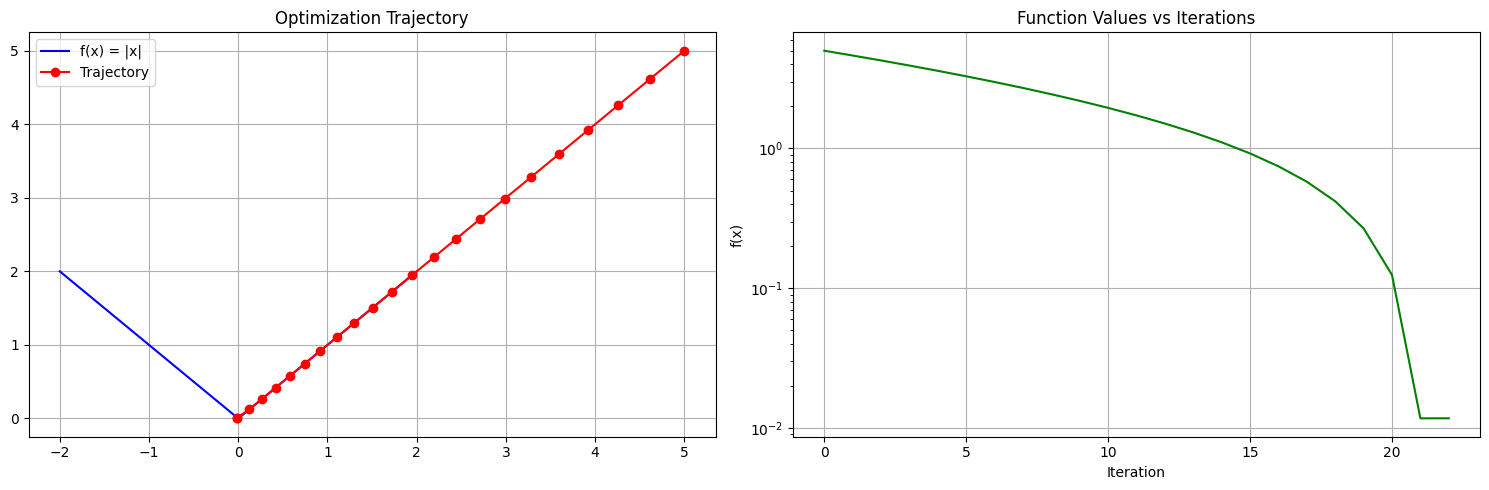

In [46]:

def f1(x: np.ndarray) -> float:
    return np.abs(x)


def plot_1d_results(trajectory: List[np.ndarray], f_values: List[float]):
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    x = np.linspace(-2, 2, 1000)
    y = np.abs(x)
    plt.plot(x, y, 'b-', label='f(x) = |x|')
    plt.plot([t[0] for t in trajectory], [f1(t) for t in trajectory],
             'ro-', label='Trajectory')
    plt.grid(True)
    plt.legend()
    plt.title('Optimization Trajectory')

    plt.subplot(122)
    plt.plot(f_values, 'g-')
    plt.grid(True)
    plt.title('Function Values vs Iterations')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('f(x)')
    plt.tight_layout()
    plt.show()

# Test the improved implementation
x0_1d = np.array([5.0])
trajectory_1d, f_values_1d = descent(f1, x0_1d, c=0.4, max_iter=3000)
plot_1d_results(trajectory_1d, f_values_1d)


Implémentation en 2D

Définition de la fonction 2D

In [5]:
def f2d(x: np.ndarray) -> float:
    return np.sum(np.abs(x))

[array([ 3., -2.]), array([ 2.962, -1.962]), array([ 2.9259, -1.9259]), array([ 2.891605, -1.891605]), array([ 2.85902475, -1.85902475]), array([ 2.82807351, -1.82807351]), array([ 2.79866984, -1.79866984]), array([ 2.77073635, -1.77073635]), array([ 2.74419953, -1.74419953]), array([ 2.71898955, -1.71898955]), array([ 2.69504007, -1.69504007]), array([ 2.67228807, -1.67228807]), array([ 2.65067367, -1.65067367]), array([ 2.63013998, -1.63013998]), array([ 2.61063298, -1.61063298]), array([ 2.59210133, -1.59210133]), array([ 2.57449627, -1.57449627]), array([ 2.55777145, -1.55777145]), array([ 2.54188288, -1.54188288]), array([ 2.52678874, -1.52678874]), array([ 2.5124493, -1.5124493]), array([ 2.49882684, -1.49882684]), array([ 2.48588549, -1.48588549]), array([ 2.47359122, -1.47359122]), array([ 2.46191166, -1.46191166]), array([ 2.45081608, -1.45081608]), array([ 2.44027527, -1.44027527]), array([ 2.43026151, -1.43026151]), array([ 2.42074843, -1.42074843]), array([ 2.41171101, -1.4

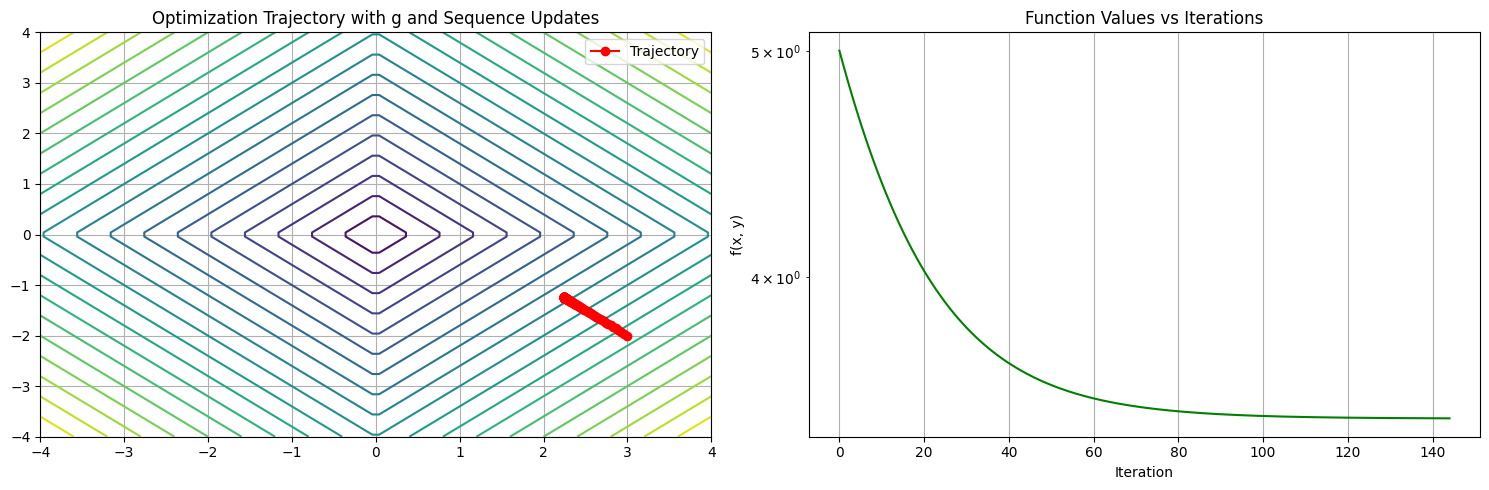

In [7]:
x0_2d = np.array([3.0, -2.0])
trajectory_2d, f_values_2d = descent(f2d, x0_2d, c=0.04, max_iter=1000)
print(trajectory_2d)

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(121)
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x, y)
Z = np.abs(X) + np.abs(Y)
plt.contour(X, Y, Z, levels=20, cmap='viridis')
plt.plot([t[0] for t in trajectory_2d], [t[1] for t in trajectory_2d],
         'ro-', label='Trajectory')
plt.grid(True)
plt.legend()
plt.title('Optimization Trajectory with g and Sequence Updates')

plt.subplot(122)
plt.plot(f_values_2d, 'g-')
plt.grid(True)
plt.title('Function Values vs Iterations')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('f(x, y)')

plt.tight_layout()
plt.show()